In [1]:
spark

In [2]:
from collections import namedtuple
import datetime
import json
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score

from pyspark.sql import Row, Window, types
import pyspark.sql.functions as sf

%load_ext autoreload
%autoreload 2

In [3]:
import project_utils
import bks_utils
import propensity_utils
from kdevries.analysis_utils import show_sorted_frequencies as ssf

In [4]:
import sys
sys.path.append("/opt/spark/work-dir/shared/bkng-etl/")
import bkng.data

In [5]:
bks_utils.create_h2o_context_on_bks()

Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Waiting for pods
Connecting to H2O server at http://bigdata-rkzd46nahh:54321 ... successful.


H2O_cluster_uptime:,23 secs
H2O_cluster_timezone:,+01:00
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,23 days
H2O_cluster_name:,user33922
H2O_cluster_total_nodes:,3
H2O_cluster_free_memory:,45 Gb
H2O_cluster_total_cores:,168
H2O_cluster_allowed_cores:,168
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.2-1-3.0
 * H2O name: spark
 * cluster size: 3
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.239.197.91,54321)
  (1,10.239.194.187,54321)
  (2,10.239.197.220,54321)
  ------------------------

  Open H2O Flow in browser: http://bigdata-rkzd46nahh:54321 (CMD + click in Mac OSX)

    


# Get data

In [6]:
DATA_START_DATE = "2019-01-01"
DATA_END_DATE = "2020-09-07" # Monday three months ago
data_df = (
    project_utils
    .get_data_df(DATA_START_DATE, DATA_END_DATE)
    .repartition(20)
    .cache()
)
data_df = project_utils.add_week_start_date_column(data_df, time_col="timestamp")

In [7]:
ssf(data_df, sf.month("yyyy_mm_dd"), sort_cols="month(yyyy_mm_dd)")

+-----------------+--------+--------+
|month(yyyy_mm_dd)|abs_freq|rel_freq|
+-----------------+--------+--------+
|1                |143875  |0.0862  |
|2                |137954  |0.0827  |
|3                |98418   |0.059   |
|4                |72704   |0.0436  |
|5                |90532   |0.0543  |
|6                |125822  |0.0754  |
|7                |234806  |0.1407  |
|8                |243486  |0.1459  |
|9                |187998  |0.1127  |
|10               |164986  |0.0989  |
|11               |88499   |0.053   |
|12               |79531   |0.0477  |
+-----------------+--------+--------+



# Train and test dates

In [8]:
test_week_start_dates = project_utils.get_week_start_date_range(start="2019-12-01", end=DATA_END_DATE)

# Prepare H2O Frame

In [9]:
metadata = json.load(open("incremental_learning_boreas_config.json"))
metadata = project_utils.set_default_model_params(metadata)
metadata = project_utils.move_categorical_features_to_numerical(metadata)
metadata["dates"] = None 

In [10]:
import propensity_utils

In [11]:
data_df = propensity_utils.add_label_and_selector_cols(data_df, test_week_start_dates)
data_h2o_df = project_utils.spark_to_h2o_frame(data_df, metadata)
data_h2o_df = propensity_utils.cast_label_and_selector_cols_as_factor(data_h2o_df, test_week_start_dates)

# Train models

In [12]:
from h2o.estimators import H2ORandomForestEstimator 

In [13]:
models = {}
features = metadata["numerical_features"] + metadata["categorical_features"]

for test_week_start_date in test_week_start_dates:
    model = H2ORandomForestEstimator(nfolds=5, max_depth=5, ntrees=50)
    target = propensity_utils.get_week_train_test_col_name(test_week_start_date)
    train_h2o_df = propensity_utils.get_train_h2o_df(data_h2o_df, test_week_start_date)
    model.train(x=features, y=target, training_frame=train_h2o_df)
    models[test_week_start_date] = model

Dropping bad and constant columns: [email_address_hash_distinct_count_detected_country_1dly_30d2h_2h]


drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |█

# Plots

In [14]:
def get_importance_sorted_features(models: Dict[datetime.date, H2ORandomForestEstimator]):
    FeatureImportanceRow = namedtuple("FeatureImportanceRow", "test_week_start_date feature_name feature_importance")
    all_feature_importances = pd.DataFrame(
        FeatureImportanceRow(test_week_start_date, feature_name, feature_importance)
        for test_week_start_date, model in models.items()
        for feature_name, _, _, feature_importance in model.varimp()
    )    
    return (
        all_feature_importances
        .groupby("feature_name")
        .mean()
        .sort_values("feature_importance", ascending=False)
        .index
        .to_list()
    )

In [15]:
importance_sorted_features = get_importance_sorted_features(models)

In [19]:
def get_propensity_classifier_results(
    models: Dict[datetime.date, H2ORandomForestEstimator],
    importance_sorted_features,
    k_most_important=10    
):
    result = pd.DataFrame(
        (test_week_start_date, *get_model_results(model, importance_sorted_features, k_most_important))
        for test_week_start_date, model in models.items() 
    )
    result.columns = (
        ["test_week_start_date", "pr_auc", "roc_auc"] + 
        importance_sorted_features[:k_most_important] + 
        ["other"] + ["total", "test"]
    )
    result["test_prevalence"] = result["test"]/result["total"]
    return result
    
    
def get_model_results(
    model,
    importance_sorted_features,
    k_most_important=10    
):
    return (
        model.aucpr(),
        model.auc(), 
        *get_variable_importances_result(
            model, 
            importance_sorted_features,
            k_most_important=10
        ),
        *get_total_test_counts(model)
    )
    
def get_variable_importances_result(
    model, 
    importance_sorted_features,
    k_most_important=10
):
    variable_importances = {
        feature_name: feature_importance
        for feature_name, _, _, feature_importance in model.varimp()
    }
    highest_importances = [
        variable_importances.get(f, 0) 
        for f in importance_sorted_features[:k_most_important]
    ]
    sum_other_importances = sum(
        variable_importances.get(f, 0) 
        for f in importance_sorted_features[k_most_important:]
    )
    return highest_importances + [sum_other_importances]

def get_total_test_counts(model):
    ((tn, fp), (fn, tp)) = model.confusion_matrix().to_list()
    total = tn + fp + fn + tp
    test = tp + fp
    return total, test

In [20]:
propensity_classifier_results = get_propensity_classifier_results(
    models, 
    importance_sorted_features, 
    k_most_important=10
)

In [21]:
importance_sorted_features

['country_pbb_age',
 'log_time_since_first_ok_bkg',
 'property_pbb_age',
 'email_address_hash_distinct_count_detected_country_1dly_30d2h_2h',
 'log_time_since_second_ok_bkg',
 'proba_booker_cc1__issuer_cc1_given_hotel_cc1',
 'proba_issuer_cc1__language_code_given_hotel_cc1',
 'sum_sales_hotel_cc1_4_0_wk',
 'proba_hotel_cc1__language_code_given_issuer_cc1',
 'proba_hotel_cc1__issuer_cc1_given_booker_cc1',
 'proba_hotel_cc1__issuer_cc1_given_language_code',
 'proba_language_code_given_hotel_cc1',
 'proba_booker_cc1_given_hotel_cc1',
 'proba_hotel_cc1_given_booker_cc1',
 'rate_fts_hotel_cc1_4_0_wk',
 'proba_booker_cc1__hotel_cc1_given_issuer_cc1',
 'proba_hotel_cc1_given_language_code',
 'proba_issuer_cc1_given_booker_cc1__hotel_cc1',
 'proba_hotel_cc1_given_issuer_cc1__language_code',
 'proba_hotel_cc1_given_booker_cc1__issuer_cc1',
 'pbb_reservation_batch_booker_email__issuer_cc1_age',
 'proba_issuer_cc1_given_booker_cc1',
 'proba_issuer_cc1_given_language_code',
 'proba_language_code_g

In [22]:
propensity_classifier_results

,test_week_start_date,pr_auc,roc_auc,country_pbb_age,log_time_since_first_ok_bkg,property_pbb_age,email_address_hash_distinct_count_detected_country_1dly_30d2h_2h,log_time_since_second_ok_bkg,proba_booker_cc1__issuer_cc1_given_hotel_cc1,proba_issuer_cc1__language_code_given_hotel_cc1,sum_sales_hotel_cc1_4_0_wk,proba_hotel_cc1__language_code_given_issuer_cc1,proba_hotel_cc1__issuer_cc1_given_booker_cc1,other,total,test,test_prevalence
0,2019-12-02,0.859228,0.963252,0.683264,0.083474,0.042583,0.000000,0.032781,0.028169,0.014630,0.014696,0.004080,0.011970,0.084352,803985,14830,0.018446
1,2019-12-09,0.839569,0.954826,0.631241,0.083441,0.046540,0.000000,0.054014,0.015920,0.028123,0.015976,0.009052,0.014016,0.101677,841927,14500,0.017222
2,2019-12-16,0.842923,0.953791,0.693969,0.103384,0.038776,0.000000,0.032464,0.015549,0.012387,0.016318,0.008512,0.012737,0.065903,874233,14432,0.016508
3,2019-12-23,0.817291,0.947970,0.648562,0.156978,0.034874,0.000000,0.030346,0.014528,0.015967,0.013336,0.004362,0.007364,0.073683,902259,14162,0.015696
4,2019-12-30,0.842908,0.958726,0.642261,0.101498,0.039170,0.000000,0.036690,0.016901,0.029268,0.006323,0.010334,0.012714,0.104840,932330,15718,0.016859
5,2020-01-06,0.860780,0.965560,0.683078,0.110639,0.038034,0.000000,0.037066,0.011309,0.009225,0.018664,0.004119,0.004664,0.083200,962918,19112,0.019848
6,2020-01-13,0.856271,0.963902,0.646455,0.091389,0.049360,0.000000,0.052701,0.013103,0.016707,0.016143,0.005359,0.004560,0.104224,987037,19812,0.020072
7,2020-01-20,0.853680,0.958785,0.654177,0.082367,0.052072,0.000000,0.039958,0.017965,0.017953,0.008829,0.007855,0.011725,0.107099,1009706,19120,0.018936
8,2020-01-27,0.867236,0.960792,0.679992,0.106218,0.038624,0.000000,0.046031,0.017341,0.006381,0.014185,0.008229,0.008841,0.074157,1034490,19442,0.018794
9,2020-02-03,0.861718,0.958098,0.643028,0.107549,0.053235,0.000000,0.056124,0.012625,0.019060,0.011183,0.007174,0.009930,0.080094,1041719,19325,0.018551


In [61]:
def propensity_plot(d, y, ylim=(0, 1)):
    date = d["test_week_start_date"]
    plt.plot(date, d[y], marker="o")
    plt.ylim(ylim)
    plt.title(f"{y!r} for train/test classifier")
    plt.xticks(rotation=90)
    plt.xlabel("Date Test week") 
    plt.grid()

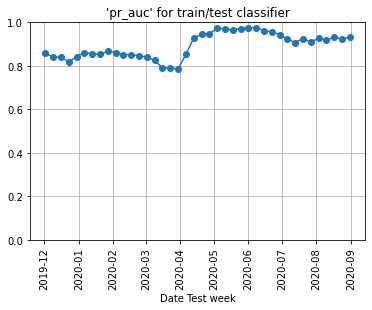

In [62]:
propensity_plot(propensity_classifier_results, "pr_auc")

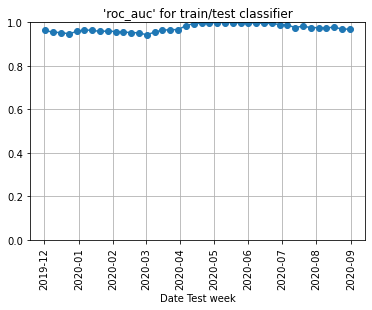

In [63]:
propensity_plot(propensity_classifier_results, "roc_auc")

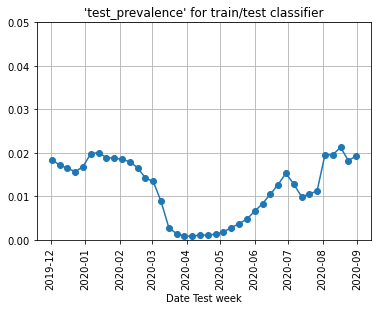

In [64]:
propensity_plot(propensity_classifier_results, "test_prevalence", ylim=(0.0, 0.05))

In [27]:
propensity_classifier_results.to_csv("propensity_classifier_results.csv")

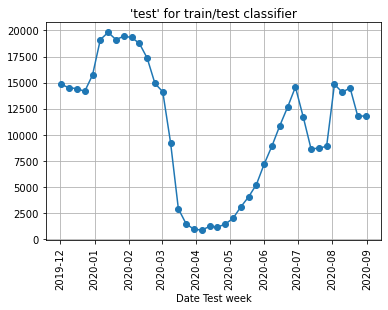

In [65]:
propensity_plot(propensity_classifier_results, "test", ylim=None)

In [66]:
def plot_importances(d, importance_columns):
    # data
    date = d["test_week_start_date"]
    importances = [d[c] for c in importance_columns]

    # colors
    tab_color_suffixes = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
    colors = [f"tab:{color_suffix}" for color_suffix in tab_color_suffixes] + ["darkblue"]

    # plot
    _, ax = plt.subplots(1)
    ax.stackplot(date, *importances, labels=importance_columns, colors=colors)
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))
    # the rest
    plt.title("Feature importances for train/test classifier")
    plt.xticks(rotation=90)
    plt.xlabel("Date Test week") 
    plt.grid()

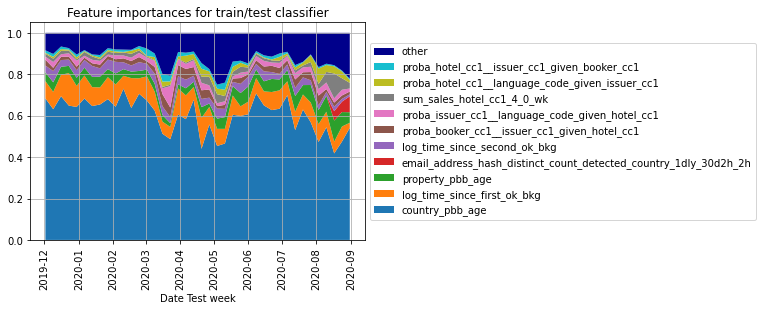

In [67]:
IMPORTANCE_START_INDEX = 3
NUM_IMPORTANCE_COLUMNS = 11
columns = propensity_classifier_results.columns.to_list()
importance_columns = columns[IMPORTANCE_START_INDEX:IMPORTANCE_START_INDEX+NUM_IMPORTANCE_COLUMNS]

plot_importances(propensity_classifier_results, importance_columns)

# Removal of obvious offenders

In [82]:
feature_models = {}
features = metadata["numerical_features"] + metadata["categorical_features"]

for feature in features[7:]:
    test_week_start_date = test_week_start_dates[0]
    model = H2ORandomForestEstimator(nfolds=5, max_depth=5, ntrees=50)
    target = propensity_utils.get_week_train_test_col_name(test_week_start_date)
    train_h2o_df = propensity_utils.get_train_h2o_df(data_h2o_df, test_week_start_date)
    try:
        model.train(x=[feature], y=target, training_frame=train_h2o_df)
        feature_models[feature] = model
    except H2OResponseError:
        pass

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |█

In [83]:
model.auc()

0.502505124239354

In [88]:
single_feature_metrics = pd.DataFrame(
    ((feature, model.auc()) for feature, model in feature_models.items()),
    columns=["feature", "auc"]
)

In [92]:
single_feature_metrics.sort_values("auc", ascending=False).head(30)

,feature,auc
48,country_pbb_age,0.959308
45,proba_issuer_cc1_given_language_code,0.814657
47,proba_language_code_given_issuer_cc1,0.780269
42,proba_issuer_cc1_given_booker_cc1,0.777397
91,sum_sales_hotel_cc1_4_0_wk,0.761763
90,rate_fts_hotel_cc1_4_0_wk,0.744687
33,proba_booker_cc1_given_issuer_cc1,0.733285
35,proba_hotel_cc1__issuer_cc1_given_language_code,0.693485
46,proba_language_code_given_hotel_cc1,0.686385
44,proba_issuer_cc1_given_hotel_cc1__language_code,0.683553


In [98]:
auc_thresholds = {"60%": 0.6, "70%": 0.7, "80%": 0.8}
auc_threshold_models = {}
test_week_start_date = test_week_start_dates[0]

for auc_key, auc_threshold in auc_thresholds.items():
    feature_selector = single_feature_metrics["auc"] < auc_threshold
    low_train_test_auc_features = single_feature_metrics[feature_selector]["feature"].to_list()
    model = H2ORandomForestEstimator(nfolds=5, max_depth=5, ntrees=50)
    target = propensity_utils.get_week_train_test_col_name(test_week_start_date)
    train_h2o_df = propensity_utils.get_train_h2o_df(data_h2o_df, test_week_start_date)
    model.train(x=low_train_test_auc_features, y=target, training_frame=train_h2o_df)
    auc_threshold_models[auc_key] = model

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [107]:
import textwrap

for auc_key, model in auc_threshold_models.items():
    auc_threshold = auc_thresholds[auc_key]
    feature_selector = single_feature_metrics["auc"] < auc_threshold
    excluded_features = single_feature_metrics[~feature_selector]["feature"].to_list()
    message = textwrap.dedent(f"""\
    When we exclude features with individual auc of >= {auc_threshold:.0%}, 
        we get a train/test ROC or {model.auc():.2%}
    
    Excluded features are: {excluded_features}
    
    
    """)
    print(message)

When we exclude features with individual auc of >= 60%, 
    we get a train/test ROC or 69.53%

Excluded features are: ['proba_booker_cc1__hotel_cc1_given_issuer_cc1', 'proba_booker_cc1__issuer_cc1_given_hotel_cc1', 'proba_booker_cc1_given_hotel_cc1', 'proba_booker_cc1_given_issuer_cc1', 'proba_hotel_cc1__issuer_cc1_given_booker_cc1', 'proba_hotel_cc1__issuer_cc1_given_language_code', 'proba_hotel_cc1__language_code_given_issuer_cc1', 'proba_hotel_cc1_given_booker_cc1', 'proba_hotel_cc1_given_booker_cc1__issuer_cc1', 'proba_hotel_cc1_given_issuer_cc1__language_code', 'proba_hotel_cc1_given_language_code', 'proba_issuer_cc1__language_code_given_hotel_cc1', 'proba_issuer_cc1_given_booker_cc1', 'proba_issuer_cc1_given_booker_cc1__hotel_cc1', 'proba_issuer_cc1_given_hotel_cc1__language_code', 'proba_issuer_cc1_given_language_code', 'proba_language_code_given_hotel_cc1', 'proba_language_code_given_issuer_cc1', 'country_pbb_age', 'property_pbb_age', 'log_time_since_first_ok_bkg', 'rate_fts_h